In [1]:
import cv2
import numpy as np
from PIL import Image

image_path = 'ImageProcessing.OOP.2017.L072/ImageProcessing.OOP.2017.L072_page2.jpeg'

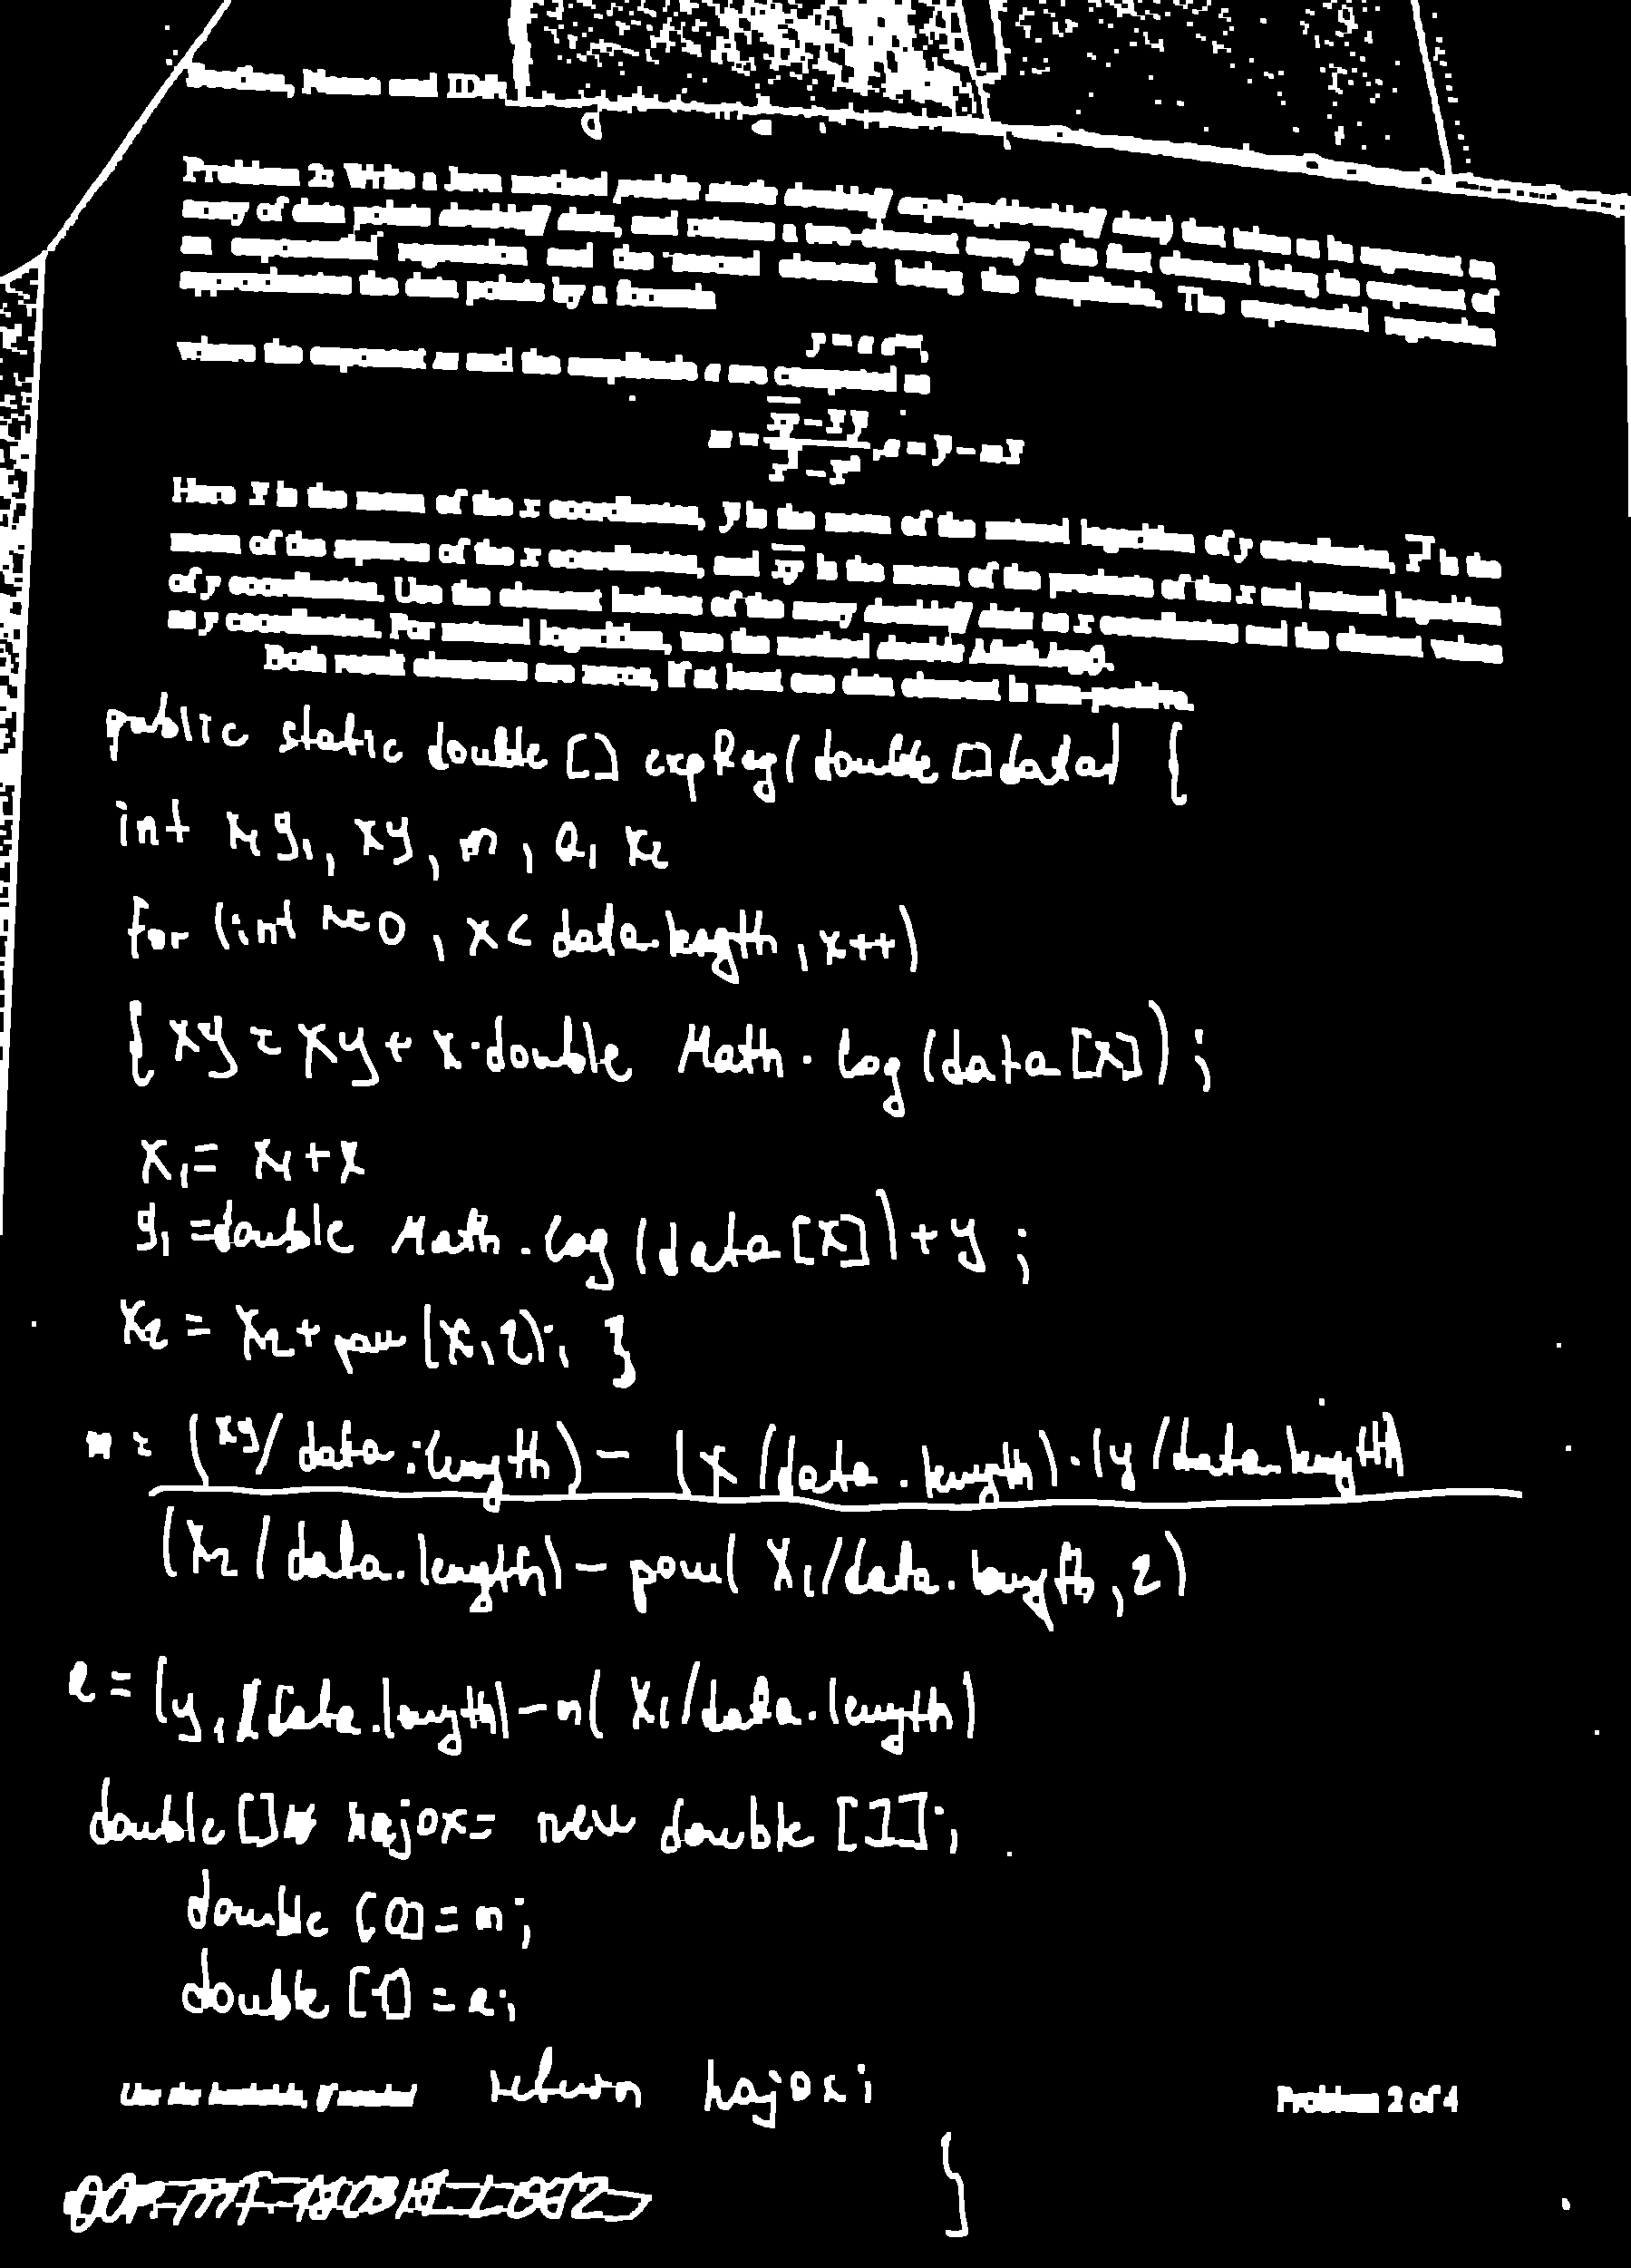

In [32]:
image = cv2.imread(image_path)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(gray, (5, 5), 0)

threshold = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 4)

kernel = np.ones((3, 3), np.uint8)
dilated = cv2.dilate(threshold, kernel, iterations=1)

morph = cv2.morphologyEx(dilated, cv2.MORPH_OPEN, kernel, iterations=2)
morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel, iterations=2)

Image.fromarray(morph)

In [33]:
import cv2
import numpy as np

def classify_text_by_distance(morph_image):
    contours, _ = cv2.findContours(morph_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    min_avg_distance_handwritten = 30  
    max_avg_distance_printed = 4      
    for contour in contours:
        total_distance = 0
        num_points = len(contour)
        for i in range(num_points - 1):
            total_distance += np.linalg.norm(contour[i] - contour[i + 1])

        avg_distance = total_distance / (num_points - 1 + 0.001)

        if min_avg_distance_handwritten < avg_distance < max_avg_distance_printed:
            cv2.drawContours(image, [contour], 0, (0, 255, 0), 2)  # Draw green for handwritten
        else:
            cv2.drawContours(image, [contour], 0, (0, 0, 255), 2)  # Draw red for printed

    return image
image = classify_text_by_distance(morph)

In [34]:
Image.fromarray(image).save('attempt1.png')

In [35]:

def classify_text_by_thickness(morph_image):
    contours, _ = cv2.findContours(morph_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    min_avg_thickness_handwritten = 5  
    max_avg_thickness_printed = 200     

    for contour in contours:
        total_thickness = 0
        num_points = len(contour)
        for i in range(num_points - 1):
            total_thickness += cv2.norm(contour[i] - contour[i + 1])

        avg_thickness = total_thickness / (num_points - 1 + 0.0000001)

        if min_avg_thickness_handwritten < avg_thickness < max_avg_thickness_printed:
            cv2.drawContours(image, [contour], 0, (0, 255, 0), 2)  #  handwritten
        else:
            cv2.drawContours(image, [contour], 0, (0, 0, 255), 2)  # printed
    return image

image = classify_text_by_thickness(morph)
Image.fromarray(image).save('attempt2.png')

In [36]:
import cv2
import numpy as np
from sklearn.cluster import KMeans

def extract_features(morph_image):
    contours, _ = cv2.findContours(morph_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    features = []
    for contour in contours:
        total_thickness = 0
        num_points = len(contour)
        for i in range(num_points - 1):
            total_thickness += cv2.norm(contour[i] - contour[i + 1])
        
        avg_thickness = total_thickness / (num_points - 1)
        features.append([avg_thickness])

    return np.array(features) , contours

def kmeans_classification(morph_image):
    # Extract features from the image
    features , contours = extract_features(morph_image)

    # Apply k-means clustering with 2 clusters
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(features)

    # Get the labels assigned by k-means
    labels = kmeans.labels_

    # Classify contours based on k-means labels
    for i, contour in enumerate(contours):
        if labels[i] == 0:
            cv2.drawContours(image, [contour], 0, (0, 255, 0), 2)  # Draw green for one class
        else:
            cv2.drawContours(image, [contour], 0, (0, 0, 255), 2)  # Draw red for the other class
    return image


image = kmeans_classification(morph)
Image.fromarray(image).save('attempt3.png')


/Users/alissa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [37]:
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def extract_features(morph_image):
    contours, _ = cv2.findContours(morph_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    features = []
    for contour in contours:
        total_thickness = 0
        num_points = len(contour)
        for i in range(num_points - 1):
            total_thickness += cv2.norm(contour[i] - contour[i + 1])
        
        avg_thickness = total_thickness / (num_points - 1)
        features.append([avg_thickness])

    return np.array(features), contours

def svm_classification(morph_image):
    features, contours = extract_features(morph_image)

    labels = np.array([0] * (len(features) // 2) + [1] * (len(features) - len(features) // 2))

    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(features, labels)

    for i, contour in enumerate(contours):
        feature = np.array([[np.average(features[:, 0])]])
        prediction = clf.predict(feature)
        if prediction == 0:
            cv2.drawContours(image, [contour], 0, (0, 255, 0), 2)  
        else:
            cv2.drawContours(image, [contour], 0, (0, 0, 255), 2)  
    return image

image = svm_classification(morph)
Image.fromarray(image).save('attempt4.png')


In [39]:
def extract_features(morph_image):
    contours, _ = cv2.findContours(morph_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    features = []
    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        aspect_ratio = 4 * np.pi * area / (perimeter * perimeter) if perimeter != 0 else 0
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        solidity = float(area) / hull_area if hull_area != 0 else 0

        features.append([area, aspect_ratio, solidity])

    return np.array(features), contours

def svm_classification(morph_image):
    # Extract features from the image
    features, contours = extract_features(morph_image)

    # Labels (0 for handwritten, 1 for printed)
    labels = np.array([0] * (len(features) // 2) + [1] * (len(features) - len(features) // 2))

    # Train a Support Vector Machine (SVM) classifier
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(features, labels)

    # Classify contours using the trained SVM
    for i, contour in enumerate(contours):
        feature = features[i]
        prediction = clf.predict([feature])  # Pass a list containing the feature
        if prediction == 0:
            cv2.drawContours(image, [contour], 0, (0, 255, 0), 2)  # Draw green for handwritten
        else:
            cv2.drawContours(image, [contour], 0, (0, 0, 255), 2)  # Draw red for printed
    return image


image = svm_classification(morph)
Image.fromarray(image).save('attempt5.png')